mass_radius
-----------

This notebook makes figures 9, 12, and 14 of the review Krumholz, McKee, & Bland-Hawthorn (2019, ARA&A, submitted). All data sources required to run this notebook are included in the notebook itself (for small data sets) or the reposistory along with the notebook (for larger data sets). The underlying data come from the following sources: [Kharchenko et al. (2013, A&A, 558, A53)](http://adsabs.harvard.edu/abs/2013A%26A...558A..53K) (Milky Way Solar neighborhood clusters, data downloaded from [VizieR](http://vizier.u-strasbg.fr/viz-bin/VizieR)), [Barmby et al., 2007, AJ, 133, 2764](http://adsabs.harvard.edu/abs/2007AJ....133.2764B) (M31 globular clusters), [Baumgardt & Hilker, 2018, MNRAS, 478, 1520](http://adsabs.harvard.edu/abs/2018MNRAS.478.1520B) (Milky Way globular clusters), [Johnson et al., 2012, AJ, 752, 95](http://adsabs.harvard.edu/abs/2012ApJ...752...95J) and [Fouesneau et al., 2014, ApJ, 786, 117](http://adsabs.harvard.edu/abs/2014ApJ...786..117F) (M31 disk clusters, data downloaded from [VizieR](http://vizier.u-strasbg.fr/viz-bin/VizieR)), [Portegies-Zwart et al., 2010, ARA&A, 48, 431](http://adsabs.harvard.edu/abs/2010ARA\%26A..48..431P), [McCrady & Graham, 2007, ApJ, 663, 844](http://adsabs.harvard.edu/abs/2007ApJ...663..844M) (M82 super star clusters), [Ryon et al., 2015, MNRAS, 452, 525](http://adsabs.harvard.edu/abs/2015MNRAS.452..525R) (M83 disk clusters, data downloaded from [VizieR](http://vizier.u-strasbg.fr/viz-bin/VizieR)), and [Ryon et al., 2017, ApJ, 841, 92](http://adsabs.harvard.edu/abs/2017ApJ...841...92R) (NGC1313 and NGC628 disk clusters, data downloaded from [VizieR](http://vizier.u-strasbg.fr/viz-bin/VizieR)).

In [1]:
# Make plots inline
%matplotlib inline

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cmap
import os.path as osp
from scipy.optimize import least_squares
from astropy.io import fits
from astropy.io import ascii as asciitab
from astropy.units import pc, kpc, Msun, Lsun, km, s, cm, Myr, K, g
from astropy.constants import G, m_p, c, k_B, sigma_sb

In [3]:
# Read the Kharchenko+ 2013 catalog for Milky Way open clusters
hdulist = fits.open('kharchenko2013_mw.fits')
mw_obj_type = hdulist[1].data['Type']
idx = np.logical_and(
    [str(st) != 'g' for st in mw_obj_type],
    hdulist[1].data['d'] <= 2e3)
mw_Sigma = hdulist[1].data['k'][idx]
mw_rt = hdulist[1].data['rt'][idx]
mw_rc = hdulist[1].data['rc'][idx]
mw_k = hdulist[1].data['k'][idx]
mw_glat = hdulist[1].data['GLAT'][idx]
mw_glon = hdulist[1].data['GLON'][idx]
mw_dist = hdulist[1].data['d'][idx]

In [4]:
# Convert Kharchenko's King profile r_t and r_c measurements into
# projected half-mass / half-number radii and mass; mass is
# derived following equation (3) of Piskunov+ 2007, A&A, 468, 151,
# using updated values of the Oort constants from Bovy+ 2017, MNRAS,
# 468, L63, and the Sun's distance from the Galactic Center from 
# Bland-Hawthorn & Gerhard, 2016, ARA&A, 54, 529; note that this
# calculation implicitly assumes that the Sun lies in the galactic
# plane, which is not exactly true (z0 ~= 25 pc), but the error
# associated with this approximation is small compared to the 
# uncertainty in the distance to the Galctic Centre
kingtab = asciitab.read('kingtab.txt')
logc = np.log10(mw_rt/mw_rc)
mw_rh = mw_rc * np.interp(logc, 
                          kingtab.columns['logc'], 
                          kingtab.columns['xh2d'])
oort_A0 = 15.3*km/s/kpc
oort_B0 = -11.9*km/s/kpc
R0 = 8.2*kpc
mw_rgc = np.sqrt(R0**2 + (mw_dist*pc)**2 - 2.0*R0*mw_dist*pc*np.cos(mw_glon*np.pi/180))
drg = (mw_rgc - R0)/R0
oort_A = oort_A0 * (1.0 - drg)
oort_A_minus_B = oort_A0 - oort_B0 - 2.0*oort_A0*drg
mw_m = np.array((4.0*oort_A*oort_A_minus_B * (mw_rt*pc)**3 / G).to('Msun'))

In [5]:
# Read Baumgardt & Hilker 2018 table for MW globulars
mw_gc_tab = asciitab.read('baumgardt2018.txt', format='fixed_width', 
                          col_starts=[0,9,20,31,38,46,52,61,70,81,92,100,
                                      107,114,121,128,136,145,153,161,
                                      169,176,183,190,198],
                          header_start=0, data_start=2)
mw_gc_m = mw_gc_tab['Mass']
mw_gc_rh = mw_gc_tab['rh,l']

In [6]:
# Read Barmby+ 2007 table for M31 globulars
m31_gc_tab = asciitab.read('barmby2007_m31.txt')
m31_gc_m = 10.**m31_gc_tab.columns['logM']
m31_gc_Sigmah = 10.**m31_gc_tab.columns['logSh']
m31_gc_rh = np.sqrt(m31_gc_m/m31_gc_Sigmah)

In [7]:
# Read Ryon et al. 2015 data on M83
hdulist = fits.open('ryon2015_m83.fits')
idx = hdulist[1].data['eta'] > 1.3   # Restrict to the clusters for which r_h is reliable
m83_rh = 10.**hdulist[1].data['logReff'][idx]
m83_m = 10.**hdulist[1].data['logMass'][idx]

In [8]:
# Read Ryon et al. 2015 data on NGC1313, NGC628
hdulist = fits.open('ryon2017_ngc1313.fits')
ngc1313_rh = 10.**hdulist[1].data['logReffc']
ngc1313_m = 10.**hdulist[1].data['logMass']
hdulist = fits.open('ryon2017_ngc628.fits')
ngc628_rh = 10.**hdulist[1].data['logReffc']
ngc628_m = 10.**hdulist[1].data['logMass']

In [9]:
# Read radii for M31 from Johnson+ 2012 catalog, using masses
# from Fouesneau+ 2014 catalog; distance to M31 taken from
# Wagner-Kaiser+ (2015, MNRAS, 451, 724)
hdulist1=fits.open('johnson2012_m31.fits')
hdulist2=fits.open('fouesneau2014_m31.fits')
pcid = list(hdulist2[1].data['PCID'])
m31_dist = 731e3  # Distance in pc
m31_rh = hdulist1[1].data['Reff']/60.**2/360.*2.0*np.pi * m31_dist
m31_m = np.array(
    [ hdulist2[1].data['logM-bset'][pcid.index(p)] 
     if p in pcid else -1.0 for p in hdulist1[1].data['PCID']])
idx = np.logical_and(
    m31_m > 0.0,
    np.isfinite(m31_m))
m31_rh = m31_rh[idx]
m31_m = 10.**m31_m[idx]

<ipython-input-9-0101daf62224>:13: RuntimeWarning: invalid value encountered in greater
  m31_m > 0.0,


In [10]:
# M51 cluster data from Chandar+ 2016
data = asciitab.read('chandar2016_m51.txt')
m51_m = 10.**data['logmass']
m51_rh = data['FWHM(pc)']

In [11]:
# Young massive clusters in the Milky Way from our compilation
data = asciitab.read('mw_ymc_compilation.txt',
                     format='basic', delimiter='\s')
mw_ymc_m = 10.**data['log_M']
mw_ymc_rh = data['rh']

In [12]:
# M82 super star clusters from McCrady & Graham (2007, ApJ, 663, 844);
# NGC 253 SSCs from Leroy et al. (2018, ApJ, submitted, arXiv:1804.02083)
# just typed in because it's a small list
m82_m = np.array([40, 5.5, 3.9, 23, 4.0, 22, 2.7, 5.7, 7.3, 2.8, 2.7,
                  8.6, 5.2, 3.0, 2.5])*1e5
m82_rh = np.array([1.4, 1.5, 1.1, 2.5, 1.6, 2.7, 1.4, 3.0, 1.4, 1.9,
                   1.5, 2.1, 1.5, 1.7, 1.7])
ngc253_m = 10.**np.array([4.3, 4.3, 4.1, 5.0, 5.4, 5.3, 4.5, 4.8, 5.5, 
                          5.3, 5.6, 6.0, 4.8, 5.5])
ngc253_rh = np.array([2.7, 1.2, 2.6, 2.5, 2.1, 2.1, 2.9, 1.9, 2.6, 
                      3.5, 2.9, 4.3, 1.6, 1.9])/2

In [13]:
# Read Urquhart+ 2018 ATLASGAL clump data
hdulist = fits.open('urquhart2018.fits')
atlasgal_m = 10.**hdulist[1].data['logMclump']
atlasgal_r = hdulist[1].data['Rad']
idx = np.logical_and(np.isfinite(atlasgal_r), atlasgal_r > 0)
atlasgal_m = atlasgal_m[idx]
atlasgal_r = atlasgal_r[idx]
hdulist.close()

<ipython-input-13-9bb22f0ff17b>:5: RuntimeWarning: invalid value encountered in greater
  idx = np.logical_and(np.isfinite(atlasgal_r), atlasgal_r > 0)


In [14]:
# Galactic center clumps from Longmore+ 2012 (first source
# listed below) and Immer+ 2012 (other three sources listed)
# that are not included in the Urquhart sample because they
# avoided the inner 5 degrees of the Galaxy
mw_galcen_m = 10.**np.array([5.1, 4.9, 5.2, 4.8])
mw_galcen_r = np.array([2.8, 3.5, 4.5, 2.7])

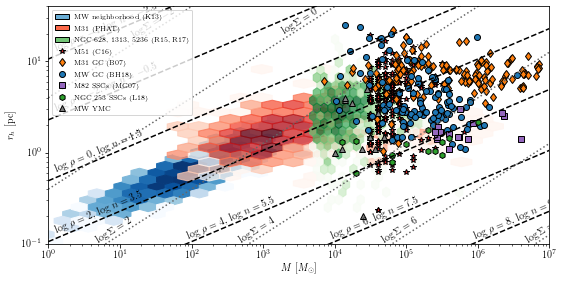

In [15]:
# Make plot
fig = plt.figure(1, figsize=(8,4))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Show larger data sets as hexbins
plt.hexbin(mw_m, mw_rh, cmap='Blues', mincnt=1, bins='log', gridsize=20,
           xscale='log', yscale='log')
plt.hexbin(m31_m, m31_rh, cmap='Reds', mincnt=1, bins='log', gridsize=15,
           xscale='log', yscale='log', alpha=0.75)
plt.hexbin(np.concatenate([m83_m, ngc1313_m, ngc628_m]), 
           np.concatenate([m83_rh, ngc1313_rh, ngc628_rh]), 
           cmap='Greens', mincnt=1, alpha=0.75,
           bins='log', gridsize=20,
           xscale='log', yscale='log')

# Add legend
handles=[]
circ1 = mpatches.Patch(fc=cmap.Blues(0.5), ec='k', label='MW neighborhood (K13)')
handles.append(circ1)
circ2 = mpatches.Patch(fc=cmap.Reds(0.5), ec='k', label='M31 (PHAT)')
handles.append(circ2)
circ3 = mpatches.Patch(fc=cmap.Greens(0.5), ec='k', label='NGC 628, 1313, 5236 (R15, R17)')
handles.append(circ3)

# Smaller samples
p,=plt.plot(m51_m, m51_rh, '*', color='C3', mec='k', label='M51 (C16)')
handles.append(p)
p,=plt.plot(m31_gc_m, m31_gc_rh, 'd', color='C1', mec='k', label='M31 GC (B07)')
handles.append(p)
p,=plt.plot(mw_gc_m, mw_gc_rh, 'o', color='C0', mec='k', label='MW GC (BH18)')
handles.append(p)
p,=plt.plot(m82_m, m82_rh, 's', color='C4', mec='k', label='M82 SSCs (MG07)')
handles.append(p)
p,=plt.plot(ngc253_m, ngc253_rh, 'h', color='C2', mec='k', label='NGC 253 SSCs (L18)')
handles.append(p)
p,=plt.plot(mw_ymc_m, mw_ymc_rh, '^', color='C7', mec='k', label='MW YMC')
handles.append(p)

# Make legend
plt.legend(handles = handles, prop={"size":7}, loc='upper left')

# Add guide lines
mlim = np.array([1,1e7])
rlim = np.array([0.1,40])
rho = [1e-4, 1e-2, 1.0, 1e2, 1e4, 1e6, 1e8]
Sigma = [1e-2, 1, 1e2, 1e4, 1e6, 1e8]
for r in rho:
    plt.plot(mlim, (3*mlim/(8*np.pi*r))**(1./3.), 'k--')
    mx = 8*np.pi*rlim[0]**3*r/3
    if mx > mlim[0]:
        plt.text(mx, 1.1*rlim[0], 
                 r'$\log\,\rho = {:d},\, \log\, n = {:3.1f}$'.
                 format(int(np.log10(r)), 
                        np.log10(float((r*Msun/pc**3/(1.4*m_p))*cm**3))),
                 rotation=23, horizontalalignment='left',
                 verticalalignment='bottom', clip_on=True)
    else:
        ry = (3*mlim[0]/(8*np.pi*r))**(1./3.)
        plt.text(1.2*mlim[0], 1.2*ry, 
                 r'$\log\,\rho = {:d},\, \log\, n = {:3.1f}$'.
                 format(int(np.log10(r)), 
                        np.log10(float((r*Msun/pc**3/(1.4*m_p))*cm**3))),
                 rotation=23, horizontalalignment='left',
                 verticalalignment='bottom', clip_on=True)
for sden in Sigma:
    plt.plot(mlim, (mlim/(2*np.pi*sden))**(1./2.), ':', color='#666666')
    mx = 2*np.pi*rlim[0]**2*sden
    if mx > mlim[0]:
        plt.text(0.7*mx, rlim[0],
                 r'$\log\Sigma={:d}$'.format(int(np.log10(sden))),
                 rotation=32, horizontalalignment='left',
                 verticalalignment='bottom', clip_on=True)
    else:
        mx = 2*np.pi*rlim[1]**2*sden
        plt.text(0.6*mx, rlim[1],
                 r'$\log\Sigma={:d}$'.format(int(np.log10(sden))),
                 rotation=32, horizontalalignment='right',
                 verticalalignment='top', clip_on=True)
        
# Axis labels and scales    
plt.xscale('log')
plt.yscale('log')
plt.xlim(mlim)
plt.ylim(rlim)
plt.xlabel(r'$M$ [$M_\odot$]')
plt.ylabel(r'$r_h$ [pc]')
plt.subplots_adjust(left=0.1, right=0.97, top=0.95)

# Save
# plt.savefig(osp.join('figures', 'mass_radius.pdf'))

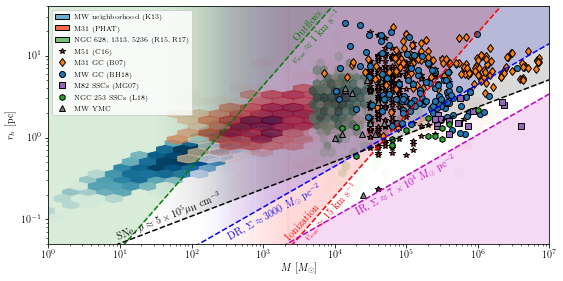

In [16]:
# Constants for theoretical lines
Psi = 1100*Lsun/Msun    # Light to mass ratio of zero-age population
T0 = 10.*K              # Normalization temperature
kappa0 = 10.**-1.5*cm**2/g  # Opacity at T0

# Make plot
fig = plt.figure(1, figsize=(8,4))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Show larger data sets as hexbins
plt.hexbin(mw_m, mw_rh, cmap='Blues', mincnt=1, bins='log', gridsize=20,
           xscale='log', yscale='log')
plt.hexbin(m31_m, m31_rh, cmap='Reds', mincnt=1, bins='log', gridsize=15,
           xscale='log', yscale='log', alpha=0.75)
plt.hexbin(np.concatenate([m83_m, ngc1313_m, ngc628_m]), 
           np.concatenate([m83_rh, ngc1313_rh, ngc628_rh]), 
           cmap='Greens', mincnt=1, alpha=0.75,
           bins='log', gridsize=20,
           xscale='log', yscale='log')

# Add legend
handles=[]
circ1 = mpatches.Patch(fc=cmap.Blues(0.5), ec='k', label='MW neighborhood (K13)')
handles.append(circ1)
circ2 = mpatches.Patch(fc=cmap.Reds(0.5), ec='k', label='M31 (PHAT)')
handles.append(circ2)
circ3 = mpatches.Patch(fc=cmap.Greens(0.5), ec='k', label='NGC 628, 1313, 5236 (R15, R17)')
handles.append(circ3)

# Smaller samples
p,=plt.plot(m51_m, m51_rh, '*', color='C3', mec='k', label='M51 (C16)')
handles.append(p)
p,=plt.plot(m31_gc_m, m31_gc_rh, 'd', color='C1', mec='k', label='M31 GC (B07)')
handles.append(p)
p,=plt.plot(mw_gc_m, mw_gc_rh, 'o', color='C0', mec='k', label='MW GC (BH18)')
handles.append(p)
p,=plt.plot(m82_m, m82_rh, 's', color='C4', mec='k', label='M82 SSCs (MG07)')
handles.append(p)
p,=plt.plot(ngc253_m, ngc253_rh, 'h', color='C2', mec='k', label='NGC 253 SSCs (L18)')
handles.append(p)
p,=plt.plot(mw_ymc_m, mw_ymc_rh, '^', color='C7', mec='k', label='MW YMC')
handles.append(p)

# Make legend
plt.legend(handles = handles, prop={"size":7}, loc='upper left')

# Add lines indicating important thresholds
mlim = np.array([1,1e7])
rlim = np.array([0.05,40])

# Parameters used in all these plots
m_blur = 0.5
n_blur = 50
alpha=0.15

# Outflows
clr='g'
v_esc = 1*km/s
r_out = (G * mlim*Msun / v_esc**2).to('pc')
plt.fill_between(mlim, r_out, [rlim[1], rlim[1]], color=clr, alpha=alpha)
plt.plot(mlim, r_out, '--', color=clr)
mx = (rlim[1]*pc * v_esc**2 / G).to('Msun')
plt.text(float(mx/Msun)/1.3, 0.95*rlim[1], 
         'Outflows',
         rotation=48, horizontalalignment='right',
         verticalalignment='top', color=clr)
plt.text(float(mx/Msun)*1.4, 0.95*rlim[1], 
         '$v_{\\mathrm{esc}} \\approx 1$ km s$^{-1}$',
         rotation=48, horizontalalignment='right',
         verticalalignment='top', color=clr)

# Photoionization
clr='r'
v_esc = 15*km/s
m_min = 700.
r_ion = (G * mlim*Msun / v_esc**2).to('pc')
plt.plot(mlim, r_ion, '--', color=clr)
for i in range(n_blur):
    mtmp = m_min * 10**(m_blur*(np.array([i,i+1])-n_blur/2)/float(n_blur/2))
    rtmp = (G * mtmp*Msun / v_esc**2).to('pc')
    alphatmp = alpha*(i+1)/n_blur
    plt.fill_between(mtmp, rtmp, [rlim[1], rlim[1]], color=clr, lw=0.0, alpha=alphatmp)
mtmp = np.array([m_min*10.**m_blur, mlim[1]])
rtmp = (G * mtmp*Msun / v_esc**2).to('pc')
plt.fill_between(mtmp, rtmp, [rlim[1], rlim[1]], color=clr, alpha=alpha, lw=0.0)
mx = (rlim[0]*pc * v_esc**2 / G).to('Msun')
plt.text(float(mx/Msun)/1.3, 1.05*rlim[0], 
         'Ionization',
         rotation=48, horizontalalignment='left',
         verticalalignment='bottom', color=clr)
plt.text(float(mx/Msun)*1.4, 1.05*rlim[0], 
         '$v_{\\mathrm{esc}} \\approx 15$ km s$^{-1}$',
         rotation=48, horizontalalignment='left',
         verticalalignment='bottom', color=clr)

# Characteristic surface density for direct radiation pressure
clr = 'b'
Sigma_ch = (Psi / (4.0*np.pi*G*c) / 0.1).to('Msun pc^-2')
m_min = 400.
r_dr = np.sqrt(mlim*Msun / (4.0*np.pi*Sigma_ch))
plt.plot(mlim, r_dr, '--', color=clr)
for i in range(n_blur):
    mtmp = m_min * 10**(m_blur*(np.array([i,i+1])-n_blur/2)/float(n_blur/2))
    rtmp = np.sqrt(mtmp*Msun / (4.0*np.pi*Sigma_ch)).to('pc')
    alphatmp = alpha*(i+1)/n_blur
    plt.fill_between(mtmp, rtmp, [rlim[1], rlim[1]], color=clr, lw=0.0, alpha=alphatmp)
mtmp = np.array([m_min*10.**m_blur, mlim[1]])
rtmp = np.sqrt(mtmp*Msun / (4.0*np.pi*Sigma_ch)).to('pc')
plt.fill_between(mtmp, rtmp, [rlim[1], rlim[1]], color=clr, alpha=alpha, lw=0.0)
mx = ((rlim[0]*pc)**2 * 4.0*np.pi*Sigma_ch).to('Msun')
plt.text(float(mx/Msun)*2.4, 1.05*rlim[0], 
         'DR, $\Sigma \\approx 3000$ $M_\odot$ pc$^{-2}$',
         rotation=29, horizontalalignment='left',
         verticalalignment='bottom', color=clr)

# Characteristic surface density for IR radiation pressure
clr = 'm'
Sigma_IR = 16.*np.sqrt(np.pi*G*sigma_sb/c)*c*T0**2 / (kappa0*Psi)
r_IR = np.sqrt(mlim*Msun / (4.0*np.pi*Sigma_IR)).to('pc')
plt.plot(mlim, r_IR, '--', color=clr)
plt.fill_between(mlim, [-10,-10], np.array(r_IR/pc), color=clr, alpha=alpha)
mx = ((0.1*pc)**2 * 4.0*np.pi*Sigma_IR).to('Msun')
plt.text(float(mx/Msun)*2.2, 1.05*0.1, 
         'IR, $\Sigma \\approx 7\\times 10^4$ $M_\odot$ pc$^{-2}$',
         rotation=29, horizontalalignment='left',
         verticalalignment='bottom', color=clr)

# SNe
clr='k'
t_SN = 3*Myr
eps_ff = 0.01
rho_SN = 3 * np.pi / (128 * G * (eps_ff * t_SN)**2)
r_SN = ((3*mlim*Msun / (4*np.pi*rho_SN))**(1./3.)).to('pc')
m_min = 100.0
plt.plot(mlim, r_SN, '--', color=clr)
for i in range(n_blur):
    mtmp = m_min * 10**(m_blur*(np.array([i,i+1])-n_blur/2)/float(n_blur/2))
    rtmp = ((3*mtmp*Msun / (4*np.pi*rho_SN))**(1./3.)).to('pc')
    alphatmp = alpha*(i+1)/n_blur
    plt.fill_between(mtmp, rtmp, [rlim[1], rlim[1]], color=clr, lw=0.0, alpha=alphatmp)
mtmp = np.array([m_min*10.**m_blur, mlim[1]])
rtmp = ((3*mtmp*Msun / (4*np.pi*rho_SN))**(1./3.)).to('pc')
plt.fill_between(mtmp, rtmp, [rlim[1], rlim[1]], color=clr, alpha=alpha, lw=0.0)
m1 = (4*np.pi*(rlim[0]*pc)**3*rho_SN/3.).to('Msun')
plt.text(m1/Msun/1.1, 1.05*rlim[0], 
         'SNe, $\\rho \\approx 5\\times 10^5 \\mu_{\\mathrm{H}}$ cm$^{-3}$',
         color=clr, rotation=22, horizontalalignment='left',
         verticalalignment='bottom')

# Axis labels and scales    
plt.xscale('log')
plt.yscale('log')
plt.xlim(mlim)
plt.ylim(rlim)
plt.xlabel(r'$M$ [$M_\odot$]')
plt.ylabel(r'$r_h$ [pc]')
plt.subplots_adjust(left=0.1, right=0.97, top=0.95)

# Save
# plt.savefig(osp.join('figures', 'mass_radius_feedback.pdf'))

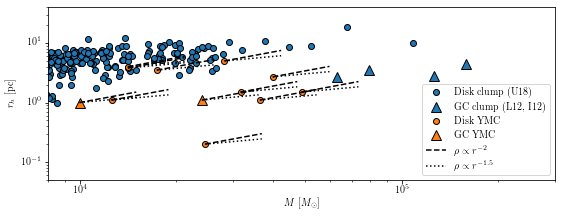

In [17]:
# Make plot
fig = plt.figure(1, figsize=(8,3))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Plot data
plt.plot(atlasgal_m, atlasgal_r, 'o', color='C0', mec='k', label='Disk clump (U18)')
plt.plot(mw_galcen_m, mw_galcen_r, '^', color='C0', mec='k', ms=10, label='GC clump (L12, I12)')
plt.plot(mw_ymc_m[2:], mw_ymc_rh[2:], 'o', color='C1', mec='k', label='Disk YMC')
plt.plot(mw_ymc_m[:2], mw_ymc_rh[:2], '^', color='C1', mec='k', ms=10, label='GC YMC')

# Plot M ~ r line from each YMC
for i, mr in enumerate(zip(mw_ymc_m, mw_ymc_rh)):
    m = mr[0]
    r = mr[1]
    if i == 0:
        label1 = r'$\rho\propto r^{-2}$'
        label2 = r'$\rho\propto r^{-1.5}$'
    else:
        label1 = ''
        label2 = ''
    f = 1.5
    plt.plot([m,f*m], [r,f*r], 'k--', label=label1)
    plt.plot([m,f*m], [r,f**0.5*r], 'k:', label=label2)

# Add legend
plt.legend()

# Adjust axes
plt.xscale('log')
plt.yscale('log')
plt.xlim([8e3,3e5])
plt.ylim(rlim)
plt.xlabel(r'$M$ [$M_\odot$]')
plt.ylabel(r'$r_h$ [pc]')
plt.subplots_adjust(left=0.1, top=0.95, right=0.98, bottom=0.15)

# Save
# plt.savefig(osp.join('figures', 'clump_cluster.pdf'))

In [18]:
# Write out a table of properties in latex format
samples = [
    { 'name' : 'Milky Way ($d<2$ kpc)', 'm' : mw_m, 'r' : mw_rh, 'ref' : 'K13' },
    { 'name' : 'M31 (PHAT)', 'm' : m31_m, 'r' : m31_rh, 'ref' : 'J12, F14' },
    { 'name' : 'NGC 5236 (M83)', 'm' : m83_m, 'r' : m83_rh, 'ref' : 'R15'},
    { 'name' : 'NGC 628 (LEGUS)', 'm' : ngc628_m, 'r' : ngc628_rh, 'ref' : 'R17'},
    { 'name' : 'NGC 1313 (LEGUS)', 'm' : ngc1313_m, 'r' : ngc1313_rh, 'ref' : 'R17'},
    { 'name' : 'M51', 'm' : m51_m, 'r' : m51_rh, 'ref' : 'C16'},
    { 'name' : 'M31 GC', 'm' : m31_gc_m, 'r' : m31_gc_rh, 'ref' : 'B07'},
    { 'name' : 'Milky Way GC', 'm' : mw_gc_m, 'r' : mw_gc_rh, 'ref' : 'BH18'},
    { 'name' : 'M82 SSC', 'm' : m82_m, 'r' : m82_rh, 'ref' : 'MG07'},
    { 'name' : 'NGC 253 SSC', 'm' : ngc253_m, 'r' : ngc253_rh, 'ref' : 'L18'},
    { 'name' : 'Milky Way YMC ($>10^4$ $M_\odot$)', 'm' : mw_ymc_m, 'r' : mw_ymc_rh, 
      'ref' : r'See \autoref{tab:ymc}'}
]
print(r"Sample   &   $\log M$ [$M_\odot$]$^{\rm a}$   &   $r_h$ [pc]$^{\rm a}$   &   $\log\Sigma$ [$M_\odot$ pc$^{-2}$]$^{\rm a,b}$    &   Reference$^{\rm c}$ \\")
print("\hline")
for s in samples:
    idx = np.logical_and(np.isfinite(s['m']), np.isfinite(s['r']))
    logm = np.log10(np.percentile(s['m'][idx], [16,50,84]))
    r = np.percentile(s['r'][idx], [16,50,84])
    logSigma = np.log10(np.percentile(s['m'][idx]/(2*np.pi*s['r'][idx]**2), [16,50,84]))
    print(("{:s}   &   ${:4.2f}_{{-{:4.2f}}}^{{+{:4.2f}}}$   &   ${:4.2f}_{{-{:4.2f}}}^{{+{:4.2f}}}$"
           "    &   ${:4.2f}_{{-{:4.2f}}}^{{+{:4.2f}}}$   &    {:s}   \\\\").
          format(s['name'], 
                 logm[1], logm[1]-logm[0], logm[2]-logm[1],
                 r[1], r[1]-r[0], r[2]-r[1],
                 logSigma[1], logSigma[1]-logSigma[0], logSigma[2]-logSigma[1],
                 s['ref']
                ))

Sample   &   $\log M$ [$M_\odot$]$^{\rm a}$   &   $r_h$ [pc]$^{\rm a}$   &   $\log\Sigma$ [$M_\odot$ pc$^{-2}$]$^{\rm a,b}$    &   Reference$^{\rm c}$ \\
\hline
Milky Way ($d<2$ kpc)   &   $1.90_{-0.55}^{+0.51}$   &   $0.58_{-0.20}^{+0.32}$    &   $1.55_{-0.30}^{+0.31}$   &    K13   \\
M31 (PHAT)   &   $3.18_{-0.55}^{+0.55}$   &   $1.56_{-0.46}^{+0.99}$    &   $1.92_{-0.45}^{+0.59}$   &    J12, F14   \\
NGC 5236 (M83)   &   $4.20_{-0.15}^{+0.34}$   &   $2.51_{-0.97}^{+1.20}$    &   $2.62_{-0.34}^{+0.56}$   &    R15   \\
NGC 628 (LEGUS)   &   $4.00_{-0.21}^{+0.40}$   &   $3.09_{-1.18}^{+2.16}$    &   $2.25_{-0.45}^{+0.56}$   &    R17   \\
NGC 1313 (LEGUS)   &   $4.10_{-0.26}^{+0.39}$   &   $2.69_{-1.67}^{+1.78}$    &   $2.51_{-0.47}^{+0.82}$   &    R17   \\
M51   &   $4.70_{-0.10}^{+0.30}$   &   $3.89_{-2.63}^{+2.99}$    &   $2.84_{-0.64}^{+0.84}$   &    C16   \\
M31 GC   &   $5.57_{-0.70}^{+0.84}$   &   $7.41_{-2.11}^{+2.54}$    &   $3.22_{-0.96}^{+0.77}$   &    B07   \\
Milky Way GC  